In [1326]:

import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from math import floor, ceil
import json
FPS = 25
CLIP_LEN = 125#

from tensorflow import keras

def score(img):
    grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    thr = cv.threshold(grey, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    img = thr[tf.newaxis, :,:, tf.newaxis]
    return int(np.argmax(model(img)))

model = keras.models.load_model('score_classifier')

In [2]:

#     "abT8l2NV9Bk": {
#         "annotations": {
#             "label": "pulling espresso shot",
#             "segment": [
#                 126.0,
#                 136.0
#             ]
#         },
#         "duration": 10.0,
#         "subset": "validate",
#         "url": "https://www.youtube.com/watch?v=abT8l2NV9Bk"

In [3]:
v= f'precut/{os.listdir("precut")[0]}'

In [1387]:
OT_L = [337,348, 234,250]
OT_R =  [337,348, 390,406]
score_R = [330,334, 380,500]
score_L = [330,334, 140,260]

num_left = [310,325, 265,285]
num_right = [310,325, 355,375]

green_box = cv.imread("greenbox.png")
red_box = cv.imread("redbox.png")
white_box = cv.imread("whitebox.png")



def left(frame):
    if (np.sum(abs(frame[score_L[0]:score_L[1], score_L[2]:score_L[3]].astype(int)-red_box.astype(int))) <= 40000):
        return True
    else:
        return False

def right(frame):
    if (np.sum(abs(frame[score_R[0]:score_R[1], score_R[2]:score_R[3]].astype(int)-green_box.astype(int))) <= 40000):
        return True
    else:
        return False
    
def check_for_score(frame):
    if left(frame) and right(frame):
        return 'both'
    elif left(frame) or right(frame):
        return 'one'
    else:
        return 'neither'
    
def go_to_start_of_light(cap, frame):
    '''
    Because we are skipping 10 frames at a time, we need to jump back to when the light first came on
    '''
    while check_for_score(frame) != 'neither':
        current_frame = cap.get(cv.CAP_PROP_POS_FRAMES)
        cap.set(cv.CAP_PROP_POS_FRAMES,current_frame-2)
        ret, frame = cap.read()
    
def jump_to_blockout_time(cap):
    current_frame = cap.get(cv.CAP_PROP_POS_FRAMES)
    cap.set(cv.CAP_PROP_POS_FRAMES,current_frame+20)
    ret, frame = cap.read()
    return frame

def jump_past_hit(cap):
    current_frame = cap.get(cv.CAP_PROP_POS_FRAMES)
    cap.set(cv.CAP_PROP_POS_FRAMES,current_frame+200)
    ret, frame = cap.read()
    return frame

def label(old_frame, current_frame):
    left_current = score(current_frame[num_left[0]:num_left[1], num_left[2]:num_left[3]])
    right_current  = score(current_frame[num_right[0]:num_right[1], num_right[2]:num_right[3]])
    left_old = score(old_frame[num_left[0]:num_left[1], num_left[2]:num_left[3]])
    right_old  = score(old_frame[num_right[0]:num_right[1], num_right[2]:num_right[3]])
    
    if left_current-left_old == 1 and right_current-right_old == 0:
        return 'left'
    elif right_current-right_old == 1 and left_current-left_old == 0:
        return 'right'
    elif right_current-right_old == 0 and left_current-left_old == 0:
        return 'together'
    else:
        return None # unclear what it is, pop the clip later
    
def not_0_or_15(frame):
    '''
    Avoids catching the weapons test at the beginning or random shit in longer videos
    '''
    if score(frame[num_left[0]:num_left[1], num_left[2]:num_left[3]]) == 0 and score(frame[num_right[0]:num_right[1], num_right[2]:num_right[3]]) == 0:
        return False
    elif score(frame[num_left[0]:num_left[1], num_left[2]:num_left[3]]) == 15 or score(frame[num_right[0]:num_right[1], num_right[2]:num_right[3]]) == 15:
        return False
    return True


def maybe_label_last(clips, frame):
    if len(clips) > 0:
        if clips[-1].label == None:
            clips[-1].label = label(clips[-1].final_img, frame)
            print(clips[-1].label)

class clip:
#     vid_id: str,
#     label: str,
#     start: float,
#     end: float,
#     start_frame: int,
#     end_frame: int,
        
    def __init__(self, vid_id, end_frame, final_img = None, label=None):
        self.vid_id = vid_id
        self.end_frame = end_frame
        if final_img is not None:
            self.final_img = final_img
        self.label = label
        

def store_clip(video_id, last_frame_idx, frame, clips):
    if len(clips) > 0:
        if clips[-1].label == None:
            print('No label, discarding')
            clips.pop() # we never managed to get a label for it
    clips.append(clip(video_id, last_frame_idx, frame))
    

# This is going to be a little tricky

# Basically, whenever we detect a light, record the score, then the blockout time to see whether the other person also hit is 25ms, so we have to jump
# ahead 7 frames, but lets make it 10 to be safe. 
# if that is both, then record the time up till then and hold onto this clip
# at the next light check to see if the score has increased, if so, label the prev

def label_video(vid_id):
    v= f'precut/{vid_id}'
    if os.path.exists(f'per_vid_labels/{vid_id.replace(".mp4", "")}'):
        print("Already have labels")
    else:
        cap = cv.VideoCapture(v)
        cap.set(cv.CAP_PROP_POS_FRAMES,1000)
        clips = []

        while cap.isOpened():
            current_frame = cap.get(cv.CAP_PROP_POS_FRAMES)
            cap.set(cv.CAP_PROP_POS_FRAMES,current_frame+10) # jump 10 frames at a time
            ret, frame = cap.read()
            # if frame is read correctly ret is True
            if not ret:
                print("Can't receive frame (stream end?). Exiting ...")
                break

            cv.imshow('frame', frame)
            if check_for_score(frame) != 'neither':

                # label the last clip now we've got a new light
                maybe_label_last(clips, frame)

                current_frame = cap.get(cv.CAP_PROP_POS_FRAMES)

                # jump ahead by the blockout time when we see a light, to ensure we see both lights if they are on
                frame = jump_to_blockout_time(cap)

                # if both lights are on, store the clip
                if check_for_score(frame) == 'both' and not_0_or_15(frame): # then its a hit which required disambiguation
                    # as we may be a few frames in, go to the beginnging, then jump forward to the blockout time precisely
                    go_to_start_of_light(cap, frame)
                    # jump ahead by the blockout time when we see a light, to ensure we get both
                    frame = jump_to_blockout_time(cap)
                    store_clip(vid_id, cap.get(cv.CAP_PROP_POS_FRAMES), frame, clips)
                    # skip the part where both are on
                    frame = jump_past_hit(cap)
                elif check_for_score(frame) == 'one':
                    pass #
                else:
                    pass


            if cv.waitKey(1) == ord('q'):
                break

        save_json(clips)
        return clips


def save_json(clips):
    json_out = {}

    for i,c in enumerate(clips):
        if c.label != None:
            start, end = c.end_frame-CLIP_LEN, c.end_frame
            start_time, end_time = start/FPS, end/FPS
            start_floor, end_ceil = float(floor(start_time)), float(ceil(end_time))
            c.vid_id = c.vid_id.replace(".mp4", "")
            json_out[f"{c.vid_id}_{i}"] = {
                    "annotations": {"label":f"{c.label}", "segment": [start_time, end_time]},
                    "annotations_frame":  {"label":f"{c.label}", "segment": [start, end]},
                    "annotations_rounded": {"label":f"{c.label}", "segment": [start_floor, end_ceil]},
                    "duration": end_time-start_time,
                    "duration_frame":end-start,
                    "duration_rounded": end_ceil-start_floor,
                    "subset": "train",
                    "url": f'https://www.youtube.com/watch?v={c.vid_id}'
            }
            
    with open(f'per_vid_labels/{c.vid_id.replace(".mp4", "")}.json', 'w') as outfile:
        json.dump(json_out, outfile)

In [1388]:
while len(os.listdir("precut")) > len(os.listdir("per_vid_labels")):
    for v in os.listdir("precut"):
        clips = label_video(v)
        

right
together
left
right
left
left
together
Can't receive frame (stream end?). Exiting ...
left
left
left
right
left
left
left
together
right
together
together
right
Can't receive frame (stream end?). Exiting ...
right
together
left
left
left
left
right
Can't receive frame (stream end?). Exiting ...
together
together
right
together
left
right
left
together
right
right
left
together
Can't receive frame (stream end?). Exiting ...
left
left
together
left
Can't receive frame (stream end?). Exiting ...
left
left
left
together
together
together
left
left
Can't receive frame (stream end?). Exiting ...
right
left
together
right
right
together
together
right
right
left
together
together
left
Can't receive frame (stream end?). Exiting ...
left
right
right
Can't receive frame (stream end?). Exiting ...
left
left
right
left
together
left
right
Can't receive frame (stream end?). Exiting ...
right
right
right
together
right
together
right
together
Can't receive frame (stream end?). Exiting ...
toge

KeyboardInterrupt: 

In [1375]:
while check_for_score(frame) != 'neither':
        current_frame = cap.get(cv.CAP_PROP_POS_FRAMES)
        cap.set(cv.CAP_PROP_POS_FRAMES,current_frame-2)
        ret, frame = cap.read()
        

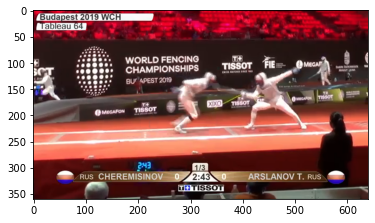

In [1376]:
plt.imshow(frame)

In [1382]:
vid_id = os.listdir("precut")[0]


right
together
left
right
left
left
together
Can't receive frame (stream end?). Exiting ...


In [1389]:
import time
def play_clip(clip, length=100):
    print(clip.label)
    v= f'precut/{clip.vid_id}'
    print(v, clip.end_frame)
    cap = cv.VideoCapture(v)
    cap.set(cv.CAP_PROP_POS_FRAMES,int(clip.end_frame-length))
    idx = 0
    while cap.isOpened() and idx < length:
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        cv.imshow('frame', frame)
        if cv.waitKey(1) == ord('q'):
            break
        idx += 1
        time.sleep(0.025)

In [1390]:
f = os.listdir('per_vid_labels')[3]
with open(f'per_vid_labels/{f}') as f:
    data = json.load(f)
    for k,v in data.items():
        vid_id = "".join(k.rsplit('_',1)[0])+'.mp4'
        end_frame = v['annotations_frame']['segment'][1]
        label = v['annotations_frame']['label']
        play_clip(clip(vid_id, end_frame, label=label))

together
precut/3Z_ZbOVXO9g.mp4 9383.0
together
precut/3Z_ZbOVXO9g.mp4 13225.0
right
precut/3Z_ZbOVXO9g.mp4 15927.0
together
precut/3Z_ZbOVXO9g.mp4 19462.0
left
precut/3Z_ZbOVXO9g.mp4 21044.0
right
precut/3Z_ZbOVXO9g.mp4 22492.0
left
precut/3Z_ZbOVXO9g.mp4 26668.0
together
precut/3Z_ZbOVXO9g.mp4 27776.0
right
precut/3Z_ZbOVXO9g.mp4 28287.0
right
precut/3Z_ZbOVXO9g.mp4 30328.0
left
precut/3Z_ZbOVXO9g.mp4 34604.0
together
precut/3Z_ZbOVXO9g.mp4 35078.0


['-bD8qlI-pxs']

In [1386]:
for c in clips:
    play_clip(c)

right
precut/-bD8qlI-pxs.mp4 2380.0
together
precut/-bD8qlI-pxs.mp4 11034.0
left
precut/-bD8qlI-pxs.mp4 13241.0
right
precut/-bD8qlI-pxs.mp4 24332.0
left
precut/-bD8qlI-pxs.mp4 30280.0
left
precut/-bD8qlI-pxs.mp4 35929.0
together
precut/-bD8qlI-pxs.mp4 39258.0


In [1343]:
os.listdir('per_vid_labels')[0]

'-bD8qlI-pxs.json'

In [1220]:
left_current = score(frame[num_left[0]:num_left[1], num_left[2]:num_left[3]])
right_current  = score(frame[num_right[0]:num_right[1], num_right[2]:num_right[3]])
print(left_current, right_current)

1 0


In [1215]:
store_clip(vid_id, cap.get(cv.CAP_PROP_POS_FRAMES), frame)

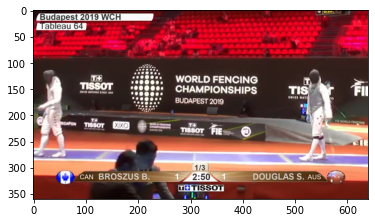

In [1225]:
ret, frame = cap.read()
plt.imshow(frame)

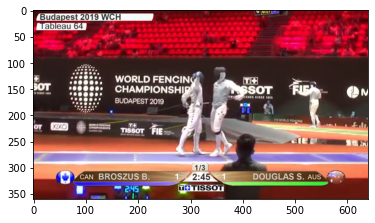

In [1227]:


plt.imshow(frame)

# Create the image dataset ugh

In [157]:
data = []
labels = []

def create_label(idx):
    vec = np.zeros(16)
    vec[idx] = 1
    return vec

In [1082]:
v= f'precut/{os.listdir("precut")[4]}'
cap = cv.VideoCapture(v)
cap.set(cv.CAP_PROP_POS_FRAMES,800)

True

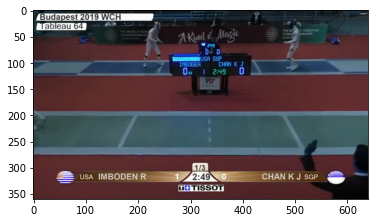

In [1188]:
current_frame = cap.get(cv.CAP_PROP_POS_FRAMES)
cap.set(cv.CAP_PROP_POS_FRAMES,current_frame+10)
ret, frame = cap.read()
plt.imshow(frame)

'\x0c'

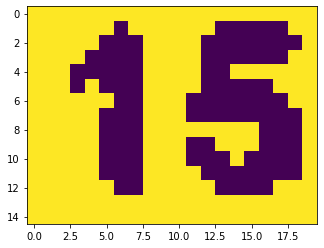

In [1073]:
num = 15


img  = frame[num_left[0]:num_left[1], num_left[2]:num_left[3]]
# img  = frame[num_right[0]:num_right[1], num_right[2]:num_right[3]]
grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
thr = cv.threshold(grey, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
plt.imshow(thr)
pytesseract.image_to_string(thr)

In [1074]:
data.append(thr)
labels.append(create_label(num))

In [1189]:
thr.shape

(15, 20)

In [1075]:
np.savez('classifierdata4', data=data, labels=labels)

In [140]:
folder = f'scoreboard_classifier_data/{num}/'
plt.imsave(f"{folder}/{len(os.listdir(folder))}.png", thr,  cmap='gray')

In [131]:
[str(i) for i in range(0,16)]

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15']

In [143]:
import tensorflow as tf
dataset  = tf.keras.preprocessing.image_dataset_from_directory('scoreboard_classifier_data', class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11', '12', '13','14','15'])
x,y = iter(dataset).next()

Found 1 files belonging to 16 classes.


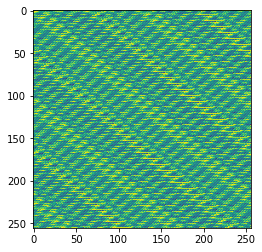

In [150]:
plt.imshow(np.resize(img, (256,256)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


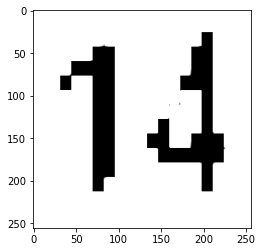

In [144]:
plt.imshow(x[0])

In [126]:
plt.imread(f"{folder}/{0}.png", cmap='gray').shape

TypeError: imread() got an unexpected keyword argument 'cmap'

In [51]:

cv.imshow('frame', frame)

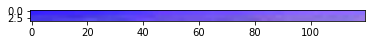

In [14]:
plt.imshow(frame[score_L[0]:score_L[1], score_L[2]:score_L[3]])

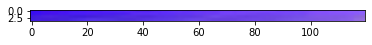

In [15]:
plt.imshow(red_box)

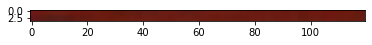

In [16]:
plt.imshow(frame[score_R[0]:score_R[1], score_R[2]:score_R[3]])

In [ ]:
cap.release()
cv.destroyAllWindows()